In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import itertools
import random

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

from scipy import stats

2024-05-31 15:31:44.295164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 15:31:45.052629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Reproducibility: set seeds for...
seed_number = 0
np.random.seed(seed_number) # numpy
random.seed(seed_number) # Python's built-in random number generator
tf.random.set_seed(seed_number) #tensorflow

In [3]:
tickers_split = [
#  ['ABBV', 'ACN'],
 ['ABBV', 'ACN', 'AEP', 'AIZ', 'ALLE', 'AMAT', 'AMP', 'AMZN', 'AVB'],
#  ['AVY', 'AXP', 'BDX', 'BF-B', 'BMY', 'BR', 'CARR', 'CDW', 'CE', 'CHTR'],
 ['CNC', 'CNP', 'COP', 'CTAS', 'CZR', 'DG', 'DPZ', 'DXC', 'META', 'FTV'],
#  ['GOOG', 'GPC', 'HIG', 'HST', 'JPM', 'KR', 'OGN', 'PG', 'PPL', 'PRU'],
 ['PYPL', 'ROL', 'ROST', 'UNH', 'URI', 'V', 'VRSK', 'WRK', 'XOM', 'IVV'],
#  ['IWM', 'EWU', 'EWG', 'EWL', 'EWQ', 'IEUS', 'EWJ', 'EWT', 'MCHI'],
 ['INDA', 'EWY', 'EWA', 'EWH', 'EWZ', 'EWC', 'IEMG', 'LQD', 'HYG', 'SHY'],
#  ['IEF', 'TLT', 'SEGA.L', 'IEAA.L', 'HIGH.L', 'JPEA.L', 'IAU', 'SLV', 'GSG', 'REET'],
 ['ICLN', 'IXN', 'IGF', 'IUVL.L', 'IUMO.L', 'SPMV.L', 'IEVL.L', 'IEFM.L', 'MVEU.L', 'XLK'],
#  ['XLF', 'XLV', 'XLE', 'XLY', 'XLI', 'XLC', 'XLU', 'XLP', 'XLB', 'VXX']
 ]

In [4]:
# Dataset
data_name = 'm6' # 'm6' or 'djia'

# Data preprocessing
index_col = 0
shrink = 0.1
feature_range = (0, 1)
train_test_split = 0.8

# Training
lstm_units = 50
epochs = 20
batch_size = 10

# Maximal window size
max_window = 2

# Load data
data_file = 'data_original_'+str(data_name)+'.csv'
data_original = pd.read_csv(data_file, index_col=index_col)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

In [ ]:
# Experiments

# Windows
look_back_new = list(range(1, max_window+1))
look_front_new = look_back_new

look_back_orig = [int(x*2) for x in look_back_new]
look_front_orig = [0] * len(look_back_orig)

back_list = list(itertools.chain(*zip(look_back_new, look_back_orig)))
front_list = list(itertools.chain(*zip(look_front_new, look_front_orig)))

# Initialize data structures
results = pd.DataFrame(columns=['ticker', 'look_back', 'look_front', 'trainScore'])

j = 0
# Iterate over tickers_split
for tickers in tickers_split:

    # Iterate over tickers
    for ticker in tickers:

        # Iterate over back and front windows
        for look_back, look_front in zip(back_list, front_list):

            # Shrink data
            nrows = int(len(data_original) * shrink)
            data = data_original.iloc[:nrows][ticker]

            # Preprocess data
            scaler = MinMaxScaler(feature_range=feature_range)
            data = scaler.fit_transform(data.values.reshape(-1, 1))

            # Split data into train and test sets
            train_size = int(len(data) * train_test_split)
            test_size = len(data) - train_size
            train, test = data[0:train_size,:], data[train_size:len(data),:]

            # Create training data
            X_train, Y_train = [], []
            for i in range(look_back, len(train) - look_front):
                a = train[i - look_back:i, 0]
                b = train[i:i + look_front, 0]
                X_train.append(np.concatenate((a, b)))
                Y_train.append(train[i, 0])
            trainX_orig, trainY = np.array(X_train), np.array(Y_train)

            # Reshape data input to be [samples, time steps, features]
            trainX = np.reshape(trainX_orig, (trainX_orig.shape[0], 1, trainX_orig.shape[1]))

            # Build model
            model = Sequential()
            model.add(LSTM(lstm_units, input_shape=(trainX.shape[0], look_back+look_front)))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Train model
            model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

            # Make predictions
            trainPredict = model.predict(trainX)

            # Invert predictions
            trainPredict = scaler.inverse_transform(trainPredict)
            trainY = scaler.inverse_transform([trainY])

            # Calculate root mean squared error
            trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
            print('Train Score: %.2f RMSE' % (trainScore))

            # Store the detailed results for the current value
            results.loc[len(results)] = [ticker, look_back, look_front, trainScore]

            # Save model
            j = j + 1
            model.save_weights(f'models/m_{j}_{ticker}_{look_back}_{look_front}_.weights.h5')

In [6]:
# Slice the DataFrame to get every other row starting from the first row
results_btf = results.iloc[::2].reset_index(drop=True)

# Slice the DataFrame to get every other row starting from the second row
results_normal = results.iloc[1::2].reset_index(drop=True)

# Create a new DataFrame with the given expressions
df_diff = pd.DataFrame({
    'trainScore_diff': np.round(((results_btf['trainScore']/results_normal['trainScore'] - 1)*100), 4),
})

def color_cells(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

# Apply the color_cells function to df_diff
df_diff_styled = df_diff.style.applymap(color_cells)
print('Value of the Future (VoF), the percentual difference from original windowing to BtF on RMSE:\n')
print('(RED values = BTF beats original windowing strategy)')
display(df_diff_styled)

print(f'\nNumber of negative elements: {(df_diff <= 0).sum().sum()} over {df_diff.shape[0]*df_diff.shape[1]} elements ({round(((df_diff <= 0).sum().sum() / (df_diff.shape[0]*df_diff.shape[1])) * 100, 2)} %)')


Value of the Future (VoF), the percentual difference from original windowing to BtF on RMSE:

(RED values = BTF beats original windowing strategy)


,trainScore_diff
0,-13.672700
1,16.228000
2,-0.901000
3,-8.252500
4,6.459900
5,-31.728000
6,-16.870900
7,-19.810900
8,3.121800
9,1.503400



Number of negative elements: 48 over 98 elements (48.98 %)


In [7]:
# Number of repeated elemens

counts = df_diff.stack().value_counts()
df_counts = counts.to_frame(name='counts')
display(df_counts[df_counts['counts'] > 1])

,counts


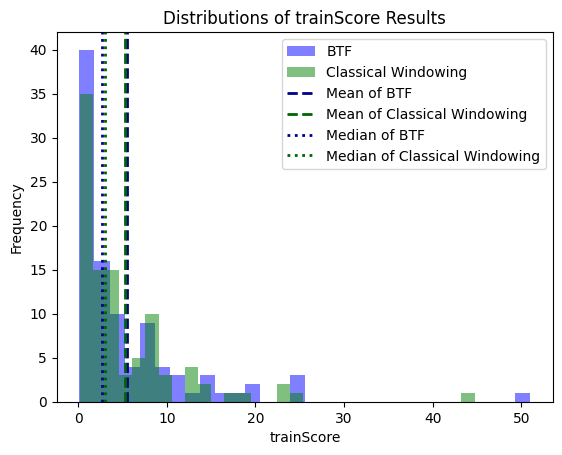

,Test,Statistic,P Value,Decision
0,Mann-Whitney U Test,4729.000000,0.855122,NOT Reject H0
1,Kruskal-Wallis H Test,0.033799,0.854134,NOT Reject H0
2,Wilcoxon Signed-Rank Test,2377.000000,0.863545,NOT Reject H0


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #


In [8]:
# Distributions and Hypothesis Testing

pvalue = 0.05

for to_plot in ['trainScore']:

    # Extract the 'trainScore' columns
    score_btf = results_btf[to_plot]
    score_normal = results_normal[to_plot]

    # Calculate the means and medians
    mean_btf = score_btf.mean()
    mean_normal = score_normal.mean()
    median_btf = score_btf.median()
    median_normal = score_normal.median()

    # Create a figure
    plt.figure()

    label_BTF = 'BTF'
    label_Normal = 'Classical Windowing'

    # Plot histograms
    plt.hist(score_btf, bins=30, color='blue', alpha=0.5, label=label_BTF)
    plt.hist(score_normal, bins=30, color='green', alpha=0.5, label=label_Normal)

    # Plot means
    plt.axvline(mean_btf, color='darkblue', linestyle='dashed', linewidth=2, label='Mean of '+label_BTF)
    plt.axvline(mean_normal, color='darkgreen', linestyle='dashed', linewidth=2, label='Mean of '+label_Normal)

    # Plot medians
    plt.axvline(median_btf, color='darkblue', linestyle='dotted', linewidth=2, label='Median of '+label_BTF)
    plt.axvline(median_normal, color='darkgreen', linestyle='dotted', linewidth=2, label='Median of '+label_Normal)

    # Add title and labels
    plt.title(f'Distributions of {to_plot} Results')
    plt.xlabel('trainScore')
    plt.ylabel('Frequency')

    # Add legend
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # Initialize a list to store the results
    results = []

    # Perform the Mann-Whitney U Test
    u_statistic, p_value = stats.mannwhitneyu(score_btf, score_normal)
    results.append(['Mann-Whitney U Test', u_statistic, p_value, 'Reject H0' if p_value < pvalue else 'NOT Reject H0'])

    # Perform the Kruskal-Wallis H Test
    h_statistic, p_value = stats.kruskal(score_btf, score_normal)
    results.append(['Kruskal-Wallis H Test', h_statistic, p_value, 'Reject H0' if p_value < pvalue else 'NOT Reject H0'])

    # Perform the Wilcoxon Signed-Rank Test
    # Note: This test requires the two samples to be paired and of the same size
    if len(score_btf) == len(score_normal):
        w_statistic, p_value = stats.wilcoxon(score_btf, score_normal)
        results.append(['Wilcoxon Signed-Rank Test', w_statistic, p_value, 'Reject H0' if p_value < pvalue else 'NOT Reject H0'])
    else:
        results.append(['Wilcoxon Signed-Rank Test', None, None, 'Cannot perform test as the samples are not of the same size.'])

    # Convert the results to a DataFrame
    df_results = pd.DataFrame(results, columns=['Test', 'Statistic', 'P Value', 'Decision'])

    # Display the DataFrame
    display(df_results)

    print('# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #')

    